# Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import load_img, img_to_array, to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from imutils import paths

# Preprocessing

initialize learning rate, epochs, batch size

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "C:\\Users\\hirem\\Desktop\\py projects\\face_mask_detection\\dataset"
CATEGORIES = ['with_mask','without_mask']

In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

one-hot encoding

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype='float32')
labels = np.array(labels)

train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

augmentation

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model

base model

In [11]:
baseModel = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

9406464/9406464 [==============================] - 1s 0us/step


head model

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

Model = Model(inputs = baseModel.input, outputs = headModel)

loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

compile

In [15]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
Model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
	metrics=["accuracy"]
)

train

In [16]:
H = Model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS
)

Epoch 1/20
34/34 [==============================] - 30s 790ms/step - loss: 0.5233 - accuracy: 0.8006 - val_loss: 0.2158 - val_accuracy: 0.9601
Epoch 2/20
34/34 [==============================] - 25s 732ms/step - loss: 0.1934 - accuracy: 0.9785 - val_loss: 0.1012 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 29s 863ms/step - loss: 0.1154 - accuracy: 0.9860 - val_loss: 0.0674 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 29s 844ms/step - loss: 0.0771 - accuracy: 0.9906 - val_loss: 0.0510 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 28s 838ms/step - loss: 0.0595 - accuracy: 0.9906 - val_loss: 0.0400 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 27s 791ms/step - loss: 0.0561 - accuracy: 0.9869 - val_loss: 0.0331 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 30s 890ms/step - loss: 0.0423 - accuracy: 0.9925 - val_loss: 0.0278 - val_accuracy: 0.9928

# Evaluation

predictions

In [17]:
pred = Model.predict(X_test, batch_size=BS)
pred = np.argmax(pred, axis=1)

9/9 [==============================] - 5s 507ms/step


In [18]:
print(classification_report(y_test.argmax(axis=1), pred, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



# Save model

In [19]:
Model.save("mask_detector.model", save_format="h5")

plot training loass and accuracy

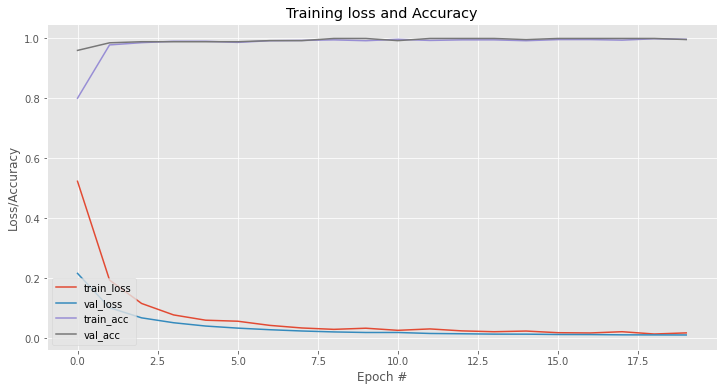

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, N), H.history['loss'], label="train_loss")
plt.plot(np.arange(0, N), H.history['val_loss'], label="val_loss")
plt.plot(np.arange(0, N), H.history['accuracy'], label="train_acc")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="val_acc")
plt.title("Training loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")